# ImageNet Categories

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import rsatoolbox
from pathlib import Path
import re
import numpy as np

In [7]:
dataset_v1 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000')
dataset_v2 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')

In [108]:
def get_dataset(image_name):
    if re.match(r'^n[0-9]+', image_name):
        return 'ImageNet'
    elif re.match(r'^COCO', image_name):
        return 'COCO'
    else:
        return 'Scene'

def sort_rdms_by_list(rdms, order):
    df = pd.DataFrame.from_dict(rdms.pattern_descriptors)
    df = df.sort_values('supercategory', key=lambda column: column.map(lambda e: order.index(e)))
    rdms.reorder(df.index)               
    
def sort_rdms_by_category(rdms):
    df = pd.DataFrame.from_dict(rdms.pattern_descriptors)
    df = df.sort_values(['dataset', 'supercategory', 'category', 'image'])
    rdms.reorder(df.index)
    
def sort_rdms(rdms):
    df = pd.DataFrame(rdms.pattern_descriptors['image'], columns=['image'])
    df['dataset'] = df.image.apply(get_dataset)
    df = df.sort_values(['dataset', 'image'])
    rdms.reorder(df.index)
    
def get_label_spans(labels):
    spans = []
    start = 0
    label = labels[0]
    for i, next_label in enumerate(labels):
        if label != next_label:
            spans.append((label, start, i))
            label = next_label
            start = i
    
    # Add last span
    spans.append((label, start, i))
    return spans
    
def plot_rdm(
    rdm,
    descriptors,
    ax=None,
    cmap=rsatoolbox.vis.colors.rdm_colormap(),
    colorbar=True
):
    if ax == None:
        ax = plt.gca()
    
    rdm_mean = rdm.dissimilarities[0].mean()
    rdm_std = rdm.dissimilarities[0].std()
    vmin = rdm_mean - rdm_std
    vmax = rdm_mean + rdm_std
    
    mat = rdm.get_matrices()[0]
    mat[np.eye(rdm.n_cond, dtype=bool)] = np.nan

    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax, interpolation ='antialiased')
    
    ax.set_title(rdm.rdm_descriptors['roi'][0], y=1.1)
    
    spans = get_label_spans(rdm.pattern_descriptors[descriptors])
    xticks = {x for s in spans for x in s[1:]}
    labels = [s[0] for s in spans]
    label_locs = [(s[1] + s[2])/2 for s in spans]
    
    ax.set_xticks(list(xticks))
    ax.set_yticks(list(xticks))
    ax.set_xticks(label_locs, labels=labels, minor=True, ha='center')
    ax.set_yticks(label_locs, labels=labels, minor=True, rotation='horizontal', va='center')
    ax.set_ylabel('Dataset')
    ax.tick_params(
        which='major',
        top=True, bottom=False, left=True, right=False,
        labeltop=False, labelbottom=False, labelleft=False, labelright=False,
    )
    ax.tick_params(
        which='minor',
        top=False, bottom=False, left=False, right=False, 
        labeltop=True, labelbottom=False, labelleft=True, labelright=False, 
    )
    
    if colorbar:
        cbar_label = rdm.dissimilarity_measure.capitalize() + ' Distance'
        cbar = plt.colorbar(im, label=cbar_label, fraction=0.045, pad=0.04, orientation='horizontal', extend='both')
        cbar.set_ticks([cbar.vmin, (cbar.vmin + cbar.vmax)/2, cbar.vmax])
        cbar.set_ticklabels(['Lesser', 'Mean', 'Greater'])
    
    return im

# def plot_rdms(rdms, ncols=2):
    

def plot_histogram(rdms, ax=None):
    if ax == None:
        ax = plt.gca()
        
    ax.hist(
        rdms.dissimilarities[0], 
        bins = 10000, 
        histtype='step'
    )
    
    ax.set_title(rdm.rdm_descriptors['roi'][0])
    
def get_single_pres(rdms):
    # Load listing of duplicate images from dataset
    repeat_df = pd.read_csv(
        dataset_v2 / 'BOLD5000_Stimuli' / 'Scene_Stimuli' / 'repeated_stimuli_113_list.txt',
        header=None,
        names=['image']
    )
    
    images_df = pd.DataFrame(rdms.pattern_descriptors['image'], columns=['image'])
    images_df = images_df[~images_df.image.isin(repeat_df.image)]
    return rdms.subsample_pattern('image', images_df.image.tolist())

SyntaxError: invalid syntax (1619280622.py, line 12)

In [93]:
rdm = rsatoolbox.rdm.load_rdm(str(dataset_v2 / 'MEAN_vcAtlas_CORR_RDMs.h5'))

In [94]:
dataset = [get_dataset(image) for image in rdm.pattern_descriptors['image']]

In [95]:
rdm.pattern_descriptors['dataset'] = dataset

In [96]:
in_rdm = rdm.subset_pattern('dataset', 'ImageNet')

In [97]:
df = pd.read_pickle(dataset_v2 / 'imagenet_categories.pkl')

In [98]:
df = df[~df.index.duplicated(keep='first')]

In [100]:
category = [df.loc[image]['category'] for image in in_rdm.pattern_descriptors['image']]

In [101]:
supercategory = [df.loc[image]['supercategory'] for image in in_rdm.pattern_descriptors['image']]

In [102]:
in_rdm.pattern_descriptors['category'] = category

In [103]:
in_rdm.pattern_descriptors['supercategory'] = supercategory

In [104]:
sort_rdms_by_category(in_rdm)

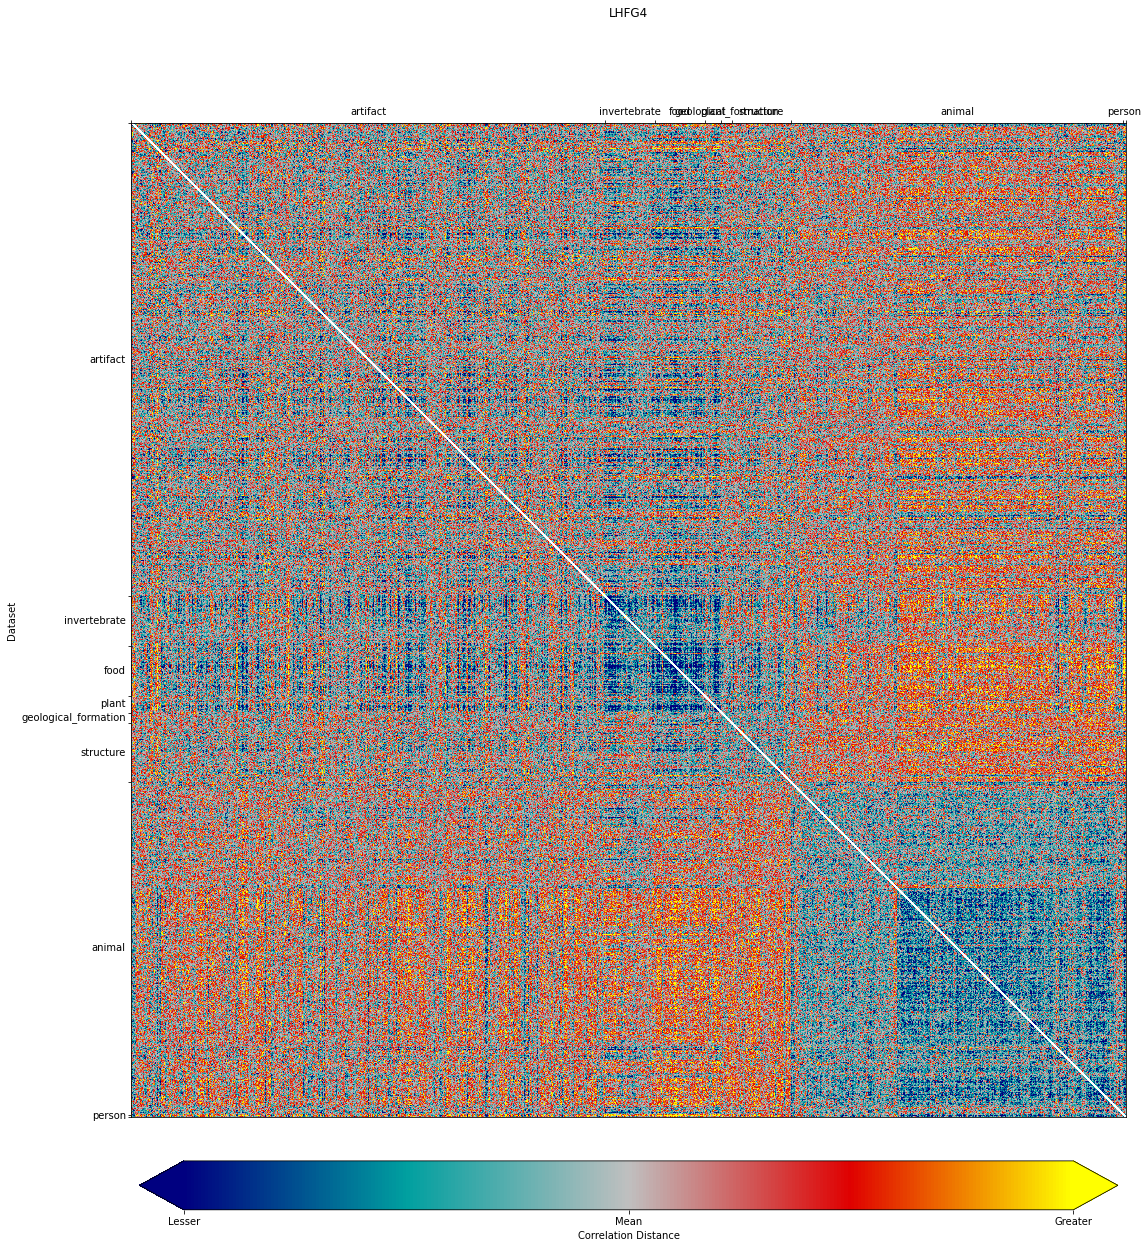

In [105]:
fig, ax = plt.subplots(figsize=(20,20))
plot_rdm(in_rdm[3], 'category', ax=ax)

In [106]:
pd.set_option("display.max_rows", None)
df.sort_values(['category', 'image'])

dataset                               synset  \
image                                                                  
n01440764_10110.JPEG   ImageNet                           tench.n.01   
n01440764_13744.JPEG   ImageNet                           tench.n.01   
n01443537_1087.JPEG    ImageNet                        goldfish.n.01   
n01443537_2819.JPEG    ImageNet                        goldfish.n.01   
n01484850_13992.JPEG   ImageNet               great_white_shark.n.01   
n01484850_22362.JPEG   ImageNet               great_white_shark.n.01   
n01491361_3094.JPEG    ImageNet                     tiger_shark.n.01   
n01491361_6719.JPEG    ImageNet                     tiger_shark.n.01   
n01494475_3853.JPEG    ImageNet                      hammerhead.n.03   
n01494475_6207.JPEG    ImageNet                      hammerhead.n.03   
n01496331_1499.JPEG    ImageNet                    electric_ray.n.01   
n01496331_7150.JPEG    ImageNet                    electric_ray.n.01   
n01498041_6496.JPEG    ImageNet                        stingray.n.01   
n01498041_984.JPEG     ImageNet                        stingray.n.01   
n01514668_15569.JPEG   ImageNet                            cock.n.05   
n01514668_4281.JPEG    ImageNet                            cock.n.05   
n01514859_10095.JPEG   ImageNet                             hen.n.02   
n01514859_8220.JPEG    ImageNet                             hen.n.02   
n01518878_5028.JPEG    ImageNet                         ostrich.n.02   
n01518878_6971.JPEG    ImageNet                         ostrich.n.02   
n01530575_3746.JPEG    ImageNet                       brambling.n.01   
n01530575_8174.JPEG    ImageNet                       brambling.n.01   
n01531178_2651.JPEG    ImageNet                       goldfinch.n.02   
n01531178_5970.JPEG    ImageNet                       goldfinch.n.02   
n01532829_11283.JPEG   ImageNet                     house_finch.n.01   
n01532829_14533.JPEG   ImageNet                     house_finch.n.01   
n01534433_436.JPEG     ImageNet                           junco.n.01   
n01534433_5650.JPEG    ImageNet                           junco.n.01   
n01537544_1343.JPEG    ImageNet                  indigo_bunting.n.01   
n01537544_5373.JPEG    ImageNet                  indigo_bunting.n.01   
n01558993_2306.JPEG    ImageNet                           robin.n.02   
n01558993_5976.JPEG    ImageNet                           robin.n.02   
n01560419_1342.JPEG    ImageNet                          bulbul.n.01   
n01560419_9017.JPEG    ImageNet                          bulbul.n.01   
n01580077_3341.JPEG    ImageNet                             jay.n.02   
n01580077_8319.JPEG    ImageNet                             jay.n.02   
n01582220_120.JPEG     ImageNet                          magpie.n.01   
n01582220_3174.JPEG    ImageNet                          magpie.n.01   
n01592084_5227.JPEG    ImageNet                       chickadee.n.01   
n01592084_5666.JPEG    ImageNet                       chickadee.n.01   
n01601694_10357.JPEG   ImageNet                     water_ouzel.n.01   
n01601694_8281.JPEG    ImageNet                     water_ouzel.n.01   
n01608432_13826.JPEG   ImageNet                            kite.n.04   
n01608432_16455.JPEG   ImageNet                            kite.n.04   
n01614925_1006.JPEG    ImageNet                      bald_eagle.n.01   
n01614925_407.JPEG     ImageNet                      bald_eagle.n.01   
n01616318_626.JPEG     ImageNet                         vulture.n.01   
n01616318_6656.JPEG    ImageNet                         vulture.n.01   
n01622779_5410.JPEG    ImageNet                  great_grey_owl.n.01   
n01622779_7389.JPEG    ImageNet                  great_grey_owl.n.01   
n01629819_19393.JPEG   ImageNet        european_fire_salamander.n.01   
n01629819_519.JPEG     ImageNet        european_fire_salamander.n.01   
n01630670_2697.JPEG    ImageNet                     common_newt.n.01   
n01630670_321.JPEG     ImageNet                     common_newt.